In [1]:
# p.403 Chapter13 TensorFlow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## 計算グラフを作成
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w * x + b
    init = tf.global_variables_initializer()
    
## セッションを作成し、計算グラフgを渡す
with tf.Session(graph=g) as sess:
    ## wとbを初期化
    sess.run(init)
    ## zを評価
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f' % (t, sess.run(z, feed_dict={x:t})))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.
x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [2]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1., 2., 3.]}))

[2.7 4.7 6.7]


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')
    
    ## 各列の合計を求める
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    
    ## 各列の平均を求める
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
    
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n', sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n', sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n', sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [5]:
class TfLinreg(object):
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        ## モデルを構築
        with self.g.as_default():
            ## グラフレベルの乱数シードを設定
            tf.set_random_seed(random_seed)
            
            self.build()
            ## 変数のイニシャライザを作成
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        ## 入力用のプレースホルダを定義
        self.X = tf.placeholder(dtype=tf.float32,
                               shape=(None, self.x_dim),
                               name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                               shape=(None),
                               name='y_input')
        print(self.X)
        print(self.y)
        
        # 重み行列とバイアスベクトルを定義
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        # オプティマイザを作成
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate,
                    name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [6]:
lrmodel = TfLinreg(x_dim = X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [7]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## すべての変数を初期化：W, b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                          feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
    return training_costs

In [8]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

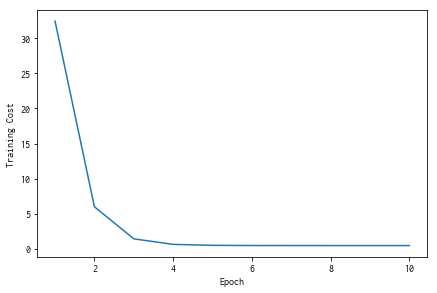

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [10]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X:X_test})
    return y_pred

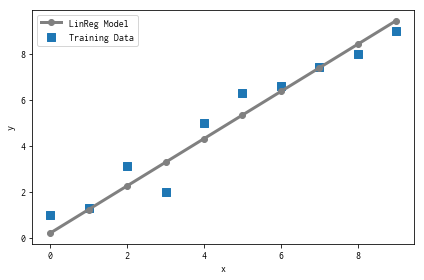

In [11]:
plt.scatter(X_train, y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]),
              predict_linreg(sess, lrmodel, X_train),
              color='gray', marker='o',
              markersize=6, linewidth=3,
              label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """MNISTデータをpathからロード"""
    # 引数に指定したパスを結合(ラベルや画像のパスを作成)
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # ファイルを読み込む：
    # 引数にファイル、モードを指定(rbは読み込みのバイナリモード)
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換：unpack関数の引数にフォーマット、8バイト分の
        # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築：fromfile関数の引数に
        # ファイル、配列のデータ形式を指定
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更
        # (行数：ラベルのサイズ、列数：特徴量の個数)
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
    return images, labels

In [13]:
## データを読み込む
X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d, Columns: %d' %(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('.', kind='t10k')
print('Rows: %d, Columns: %d' %(X_test.shape[0], X_test.shape[1]))

## 標準化と正規化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val
del X_train, X_test
print(X_train_centered.shape, y_train.shape)

print(X_test_centered.shape, y_test.shape)

Rows: 60000, Columns: 784
Rows: 10000, Columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,
                         shape=(None, n_features),
                         name='tf_x')
    tf_y = tf.placeholder(dtype=tf.int32,
                         shape=None,
                         name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    h1 = tf.layers.dense(inputs=tf_x,
                        units=50,
                        activation=tf.tanh,
                        name='layer1')
    h2 = tf.layers.dense(inputs=h1,
                        units=50,
                        activation=tf.tanh,
                        name='layer2')    
    logits = tf.layers.dense(inputs=h2,
                            units=10,
                            activation=None,
                            name='layer3')
    predictions = {
        'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits, name='softmax_tensor')
    }
    
## コスト関数とオプティマイザを定義
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot,
                                          logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()
    
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])
        
## 計算グラフを起動するためのセッションを作成
sess = tf.Session(graph=g)

## 変数のイニシャライザを実行
sess.run(init_op)

## 50エポックのトレーニング
training_costs = []
for epoch in range(50):
    traing_loss = []
    batch_generator = create_batch_generator(X_train_centered, y_train,
                                            batch_size=64)
    for batch_X, batch_y in batch_generator:
        ## ニューラルネットワークにデータを供給するためのディクショナリを準備
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
    print(' -- Epoch %2d  '
         'Avg. Training Loss: %.4f' % (epoch + 1, np.mean(training_costs)))

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
 -- Epoch  1  Avg. Training Loss: 1.5573
 -- Epoch  2  Avg. Training Loss: 1.2532
 -- Epoch  3  Avg. Training Loss: 1.0854
 -- Epoch  4  Avg. Training Loss: 0.9738
 -- Epoch  5  Avg. Training Loss: 0.8924
 -- Epoch  6  Avg. Training Loss: 0.8296
 -- Epoch  7  Avg. Training Loss: 0.7794
 -- Epoch  8  Avg. Training Loss: 0.7381
 -- Epoch  9  Avg. Training Loss: 0.7032
 -- Epoch 10  Avg. Training Loss: 0.6734
 -- Epoch 11  Avg. Training Loss: 0.6475
 -- Epoch 12  Avg. Training Loss: 0.6247
 -- Epoch 13  Avg. Training Loss: 0.6045
 -- Epoch 14  Avg. Training Loss: 0.5864
 -- Epoch 15  Avg. Training Loss: 0.5700
 -- Epoch 16  Avg. Training Loss: 0.5551
 -- Epoch 17  Avg. Training Loss: 0.5415
 -- Epoch 18  Avg. Training Loss: 0.5290
 -- Epoch 19  Avg. Training Loss: 0.5175
 -- Epoch 20  Avg. Training Loss: 0.5068
 -- Epoch 21  Avg. Training Loss: 0.4968
 -- Epoch 22  Avg. Training Loss

In [15]:
## テストデータセットで予測を行う
feed = {tf_x: X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)

print('Test Accuracy: %.2f%%' %
     (100 * np.sum(y_pred == y_test) / y_test.shape[0]))

Test Accuracy: 93.89%


In [16]:
X_train, y_train = load_mnist('./', kind='train')
print('Rows: %d, Columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('./', kind='t10k')
print('Rows: %d, Columns: %d' % (X_test.shape[0], X_test.shape[1]))

## 標準化と正規化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centerd = (X_test - mean_vals) / std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)

print(X_test_centered.shape, y_test.shape)

Rows: 60000, Columns: 784
Rows: 10000, Columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [17]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#import keras

#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
import shutil
import os
import struct

import keras

np.random.seed(123)
tf.set_random_seed(123)

Using TensorFlow backend.


In [18]:
y_train_onehot = keras.utils.to_categorical(y_train)
print('First 3 labels: ', y_train[:3])

print('\nFirst 3 labels (one-hot):\n', y_train_onehot[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [19]:
from tensorflow.keras import backend

# モデルを初期化
model = keras.models.Sequential()

# 1つ目の隠れ層を追加
model.add(keras.layers.Dense(units=50,
                            input_dim = X_train_centered.shape[1],
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            activation='tanh'))
# 2つ目の隠れ層を追加
model.add(keras.layers.Dense(units=50,
                            input_dim=50,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            activation='tanh'))

# 出力層を追加
model.add(keras.layers.Dense(units=y_train_onehot.shape[1],
                            input_dim=50,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros',
                            activation='softmax'))

# モデルコンパイル時のオプティマイザを指定
# 引数に学習率、荷重減衰定数、モーメンタム学習を設定
sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=.9)

# オプティマイザとコスト関数を指定してモデルをコンパイル
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')

In [20]:
history = model.fit(X_train_centered,
                   y_train_onehot,
                   batch_size=64,
                   epochs=50,
                   verbose=1,
                   validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 31us/step - loss: 0.7279 - val_loss: 0.3675
Epoch 2/50
54000/54000 [==============================] - 2s 30us/step - loss: 0.3736 - val_loss: 0.2835
Epoch 3/50
54000/54000 [==============================] - 2s 28us/step - loss: 0.3080 - val_loss: 0.2451
Epoch 4/50
54000/54000 [==============================] - 2s 30us/step - loss: 0.2711 - val_loss: 0.2212
Epoch 5/50
54000/54000 [==============================] - 1s 27us/step - loss: 0.2453 - val_loss: 0.2035
Epoch 6/50
54000/54000 [==============================] - 1s 27us/step - loss: 0.2252 - val_loss: 0.1904
Epoch 7/50
54000/54000 [==============================] - 2s 29us/step - loss: 0.2090 - val_loss: 0.1800
Epoch 8/50
54000/54000 [==============================] - 2s 30us/step - loss: 0.1951 - val_loss: 0.1716
Epoch 9/50
54000/54000 [==============================] - 2s 29us/step - loss: 0.1830 - val_loss: 0.1646
Epoch 

In [21]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [22]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print('First 3 predictions ', y_train_pred[:3])

print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

First 3 predictions  [5 0 4]
Training accuracy: 98.93%
Test accuracy: 96.13%


In [23]:
import numpy as np
X = np.array([1, 1.4, 2.5]) # 1つ目の値は1でなければならない
w = np.array([0.4, 0.3, 0.5])
def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w))

P(y=1|x) = 0.888


In [24]:
# W : array, shape = (n_output_units, n_hidden_units+1)
#     この配列の最初の列(w[:][0])はバイアスユニット
W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : array, shape = (n_hidden_units + 1, n_samples)
#     この配列の最初の列(A[0][0])は1でなければならない
A = np.array([[1, 0.1, 0.4, 0.6]])

# Z : array, shape = [n_output_units, n_samples]
#     出力層の総出力
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas)

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [25]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class)

Predicted class label: 0


In [26]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

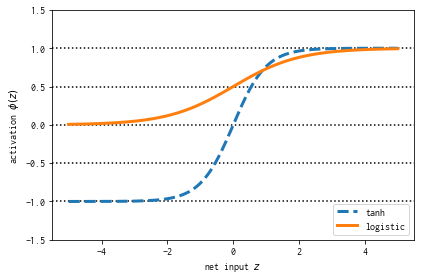

In [27]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act, linewidth=3, linestyle='--', label='tanh')
plt.plot(z, log_act, linewidth=3, label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [28]:
tanh_act = np.tanh(z)

from scipy.special import expit
log_act = expit(z)